# Imports
Originally written in Python 2 and later ported to Python 3, everything should work fine however may get error messages when importing and when making models using statsmodels.api.

In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as st
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from scipy import stats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Read Processed Data
Use 2009-2014 seasons as training data.

In [2]:
data = pd.read_csv("reg_down_data.csv")
train_data = data[data["Season"] < 2015]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Make Expected Points (EP) Model
Predicting value of "next_score" target generated in 1_Data_Prep.ipynb.

In [3]:
EP_y = train_data["next_score"] # next score expected points model using multinomial logisitic regression
EP_x_variables = ["time_remaining_in_half", "yrdline100", "ydstogo", "down", "ScoreDiff"]
EP_x = train_data[EP_x_variables]
EP_x = st.add_constant(EP_x, prepend = False)
EP_mdl = st.MNLogit(EP_y, EP_x)
EP_mdl = EP_mdl.fit()
pickle.dump(EP_mdl, open("Models/EP_model.sav", "wb"))2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 1.329545
         Iterations 10


# Make Win Probability (WP) Models
Target "is_winner". Creating multiple models here - a multinomial logicistic regression, a generalized linear logistic model, and a random forest - in order to evaluate and discover best model later.

In [4]:
WP_y = train_data["is_winner"]
WP_x_variables = ["TimeSecs", "yrdline100", "ydstogo", "is_first_down", "is_second_down", "is_third_down", "is_fourth_down", "ScoreDiff", "total_score", "is_home_team", "pos_timeouts", "def_timeouts"]
WP_x = train_data[WP_x_variables]
WP_xc = st.add_constant(WP_x, prepend = False)

# multinomial logisitic regression
multinomial_WP_mdl = st.MNLogit(WP_y, WP_xc)
multinomial_WP_mdl = multinomial_WP_mdl.fit()
pickle.dump(multinomial_WP_mdl, open("Models/multinomial_WP_model.sav", "wb"))

# sklearn generalized linear logistic model
logit_WP_mdl = st.Logit(WP_y, WP_xc)
logit_WP_mdl = logit_WP_mdl.fit()
pickle.dump(logit_WP_mdl, open("Models/logistic_WP_model.sav", "wb"))

# random forests
rf_WP_mdl = RandomForestRegressor(n_estimators = 100) # 100 decision trees
rf_WP_mdl = rf_WP_mdl.fit(WP_x, WP_y)
pickle.dump(rf_WP_mdl, open("Models/rf_WP_model.sav", "wb"))

         Current function value: 0.642047
         Iterations: 35


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.484247
         Iterations 6


# Calculate EP, Expected Points Added (EPA), WP, and Win Probability Added (WPA)
Calculate for every play 2009-2017, not just test set.

EPA is difference in EP of possession team after current play versus before current play. WPA is the same for WP.

Disclaimer: This will potentially create some biases when analyzing results from the 2009-2014 portion of our data later on. I'm aware that this isn't good statistical/data science practice, however for the sake/scope of this project it seems alright and in fact preferable in order to examine more teams, coaches, and trends over time.

Creating "aaron_EP" column representing the EP value generated from my model (original dataset came with EP and WP values already), however for this project I will need to create and use my own models in order to test theoretical situations.

In [5]:
def calculate_EP(row, EP_x_variables, EP_mdl):
    row_x = row[EP_x_variables].tolist()
    row_x.append(1) # constant used in model
    EP_mdl_preds = EP_mdl.predict(row_x)[0]
    EP_preds = [s*p for s, p in zip([-7,-3,-2,0,2,3,7], EP_mdl_preds)]
    
    return sum(EP_preds)

In [6]:
data["aaron_EP"] = data.apply(lambda row: calculate_EP(row, EP_x_variables, EP_mdl), axis=1)

### Creating "aaron_EPA" column

In [7]:
EPA_list = []
for index, row in data[:-1].iterrows():
    if row["Drive"] == data.at[index+1,"Drive"]:
        EPA_list.append(data.at[index+1,"aaron_EP"] - row["aaron_EP"])
    elif row["drive_score"] != 0:
        EPA_list.append(row["drive_score"] - row["aaron_EP"])
    else:
        EPA_list.append(-row["aaron_EP"])
EPA_list.append(0) # last play of the data set -- appending 0 is imperfect solution

data["aaron_EPA"] = EPA_list

### Creating "aaron_multinomial_WP", "aaron_logit_WP", and "aaron_rf_WP" columns
Warning: this section takes quite some time to run.

In [8]:
def calculate_WP(row, WP_x_variables, multinomial_WP_mdl, logit_WP_mdl, rf_WP_mdl):
    if row["index1"] % 10000 == 0:
        print("calculate_WP: " + str(row["index1"]))
        
    row_x = row[WP_x_variables].tolist()
    row_xc = row_x + [1] # constant
    multinomial_win_mdl_preds = multinomial_WP_mdl.predict(row_xc)[0] # outputs are probability of loss, tie, win
    multinomial_win_preds = [v*p for v, p in zip([0,0.5,1], multinomial_win_mdl_preds)]
    arr = np.array(row_x).reshape(1,-1)
    
    return (sum(multinomial_win_preds), logit_WP_mdl.predict(row_xc)[0], rf_WP_mdl.predict(arr)[0])

In [9]:
data["index1"] = data.index
(data["aaron_multinomial_WP"], data["aaron_logit_WP"], data["aaron_rf_WP"]) = zip(*data.apply(lambda row: calculate_WP(row, WP_x_variables, multinomial_WP_mdl, logit_WP_mdl, rf_WP_mdl), axis=1))
data.pop("index1")

calculate_WP: 0
calculate_WP: 10000
calculate_WP: 20000
calculate_WP: 30000
calculate_WP: 40000
calculate_WP: 50000
calculate_WP: 60000
calculate_WP: 70000
calculate_WP: 80000
calculate_WP: 90000
calculate_WP: 100000
calculate_WP: 110000
calculate_WP: 120000
calculate_WP: 130000
calculate_WP: 140000
calculate_WP: 150000
calculate_WP: 160000
calculate_WP: 170000
calculate_WP: 180000
calculate_WP: 190000
calculate_WP: 200000
calculate_WP: 210000
calculate_WP: 220000
calculate_WP: 230000
calculate_WP: 240000
calculate_WP: 250000
calculate_WP: 260000
calculate_WP: 270000
calculate_WP: 280000
calculate_WP: 290000
calculate_WP: 300000
calculate_WP: 310000
calculate_WP: 320000
calculate_WP: 330000
calculate_WP: 340000


0              0
1              1
2              2
3              3
4              4
           ...  
344054    344054
344055    344055
344056    344056
344057    344057
344058    344058
Name: index1, Length: 344059, dtype: int64

### Creating "aaron_multinomial_WPA", "aaron_logit_WPA", and "aaron_rf_WPA" columns

In [10]:
def find_WPA(data, col_name):
    WPA_list = []
    for index, row in data[:-1].iterrows():
        if row["GameID"] == data.at[index+1, "GameID"]:
            if row["posteam"] == data.at[index+1, "posteam"]:
                WPA_list.append(data.at[index+1 ,col_name] - row[col_name])
            else:
                WPA_list.append((1 - data.at[index+1, col_name]) - row[col_name])
        else: # last play of game
            WPA_list.append(row["is_winner"] - row[col_name])
            
        if index % 50000 == 0:
            print(col_name + " " + str(index) + "/" + str(max(data.index)))

    # last play of dataset
    WPA_list.append((data.loc[data.index.max(), "is_winner"]) - data.loc[data.index.max(), col_name])
    data["col_name"] = WPA_list
    
    return data.rename(columns={"col_name": (col_name + "A")})

In [11]:
data = find_WPA(data, "aaron_multinomial_WP")
data = find_WPA(data, "aaron_logit_WP")
data = find_WPA(data, "aaron_rf_WP")

aaron_multinomial_WP 0/344058
aaron_multinomial_WP 50000/344058
aaron_multinomial_WP 100000/344058
aaron_multinomial_WP 150000/344058
aaron_multinomial_WP 200000/344058
aaron_multinomial_WP 250000/344058
aaron_multinomial_WP 300000/344058
aaron_logit_WP 0/344058
aaron_logit_WP 50000/344058
aaron_logit_WP 100000/344058
aaron_logit_WP 150000/344058
aaron_logit_WP 200000/344058
aaron_logit_WP 250000/344058
aaron_logit_WP 300000/344058
aaron_rf_WP 0/344058
aaron_rf_WP 50000/344058
aaron_rf_WP 100000/344058
aaron_rf_WP 150000/344058
aaron_rf_WP 200000/344058
aaron_rf_WP 250000/344058
aaron_rf_WP 300000/344058


# Save Data

In [12]:
data.to_csv("data_with_EP_WP.csv", encoding="utf-8", index=False)

# MODEL EVALUATION

# Test EP Model Accuracy
Use 2015-2017 seasons as test set.

In [13]:
test_data = data[data["Season"] >= 2015]

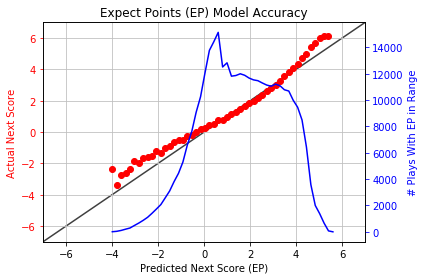

In [15]:
custom_bucket_array = np.linspace(data["aaron_EP"].min(), data["aaron_EP"].max(), 51)
data["aaron_EP_bucket_interval"] = pd.cut(data["aaron_EP"], custom_bucket_array)
data["bucket_mean"] = data.aaron_EP_bucket_interval.map(data.groupby(["aaron_EP_bucket_interval"]).next_score.mean())
data["aaron_EP_bucket_digitize_index"] = np.digitize(data["aaron_EP"], custom_bucket_array, right=True)
data["aaron_EP_bucket_digitize"] = custom_bucket_array[data["aaron_EP_bucket_digitize_index"]-1]

fig, ax1 = plt.subplots()
x1 = data.aaron_EP_bucket_digitize.unique()
y1 = data.bucket_mean.unique()
ax1.plot(list(x1), list(y1), "ro")
ax1.set_title("Expect Points (EP) Model Accuracy")
ax1.set_xlabel("Predicted Next Score (EP)")
ax1.set_ylabel("Actual Next Score", color="r")
ax1.tick_params("y", colors="r")
ax1.set_xlim(-7, 7)
ax1.set_ylim(-7, 7)
ax1.plot([-7, 7], [-7, 7], "k-", alpha=0.75, zorder=0)
ax1.grid(True, linestyle="-", color="0.75")

ax2 = ax1.twinx()
lists = sorted(data["aaron_EP_bucket_digitize"].value_counts().to_dict().items())
x2, y2 = zip(*lists)
ax2.plot(x2, y2, "b")
ax2.set_ylabel("# Plays With EP in Range", color="b")
ax2.tick_params("y", colors="b")

fig.tight_layout()
plt.show()

# correlation = data.corr().at["aaron_EP_bucket_digitize", "bucket_mean"] # KeyError using "bucket_mean"
# print("Correlation between Predicted (EP) and Actual Next Score: " + str(correlation))

# Test WP Models Accuracy
Bin each model's predictions into 5-minute interval to see how models perform versus one another and how their performance changes throughout the course of a game.

In [16]:
def calculate_WP_accuracy(test_data, num_buckets, model_name, col_name):
    minutes = []
    correlations = []
    briers = []
    residuals = []

    print(model_name + ":")
    for mins in range(12):
        data = test_data[test_data["TimeSecs"] <= (12-mins)*300] # 300 = 60 seconds/min * 5 min/interval
        data = data[data["TimeSecs"] > (12-(mins+1))*300]
        minutes.append(str((12-mins)*5) + "-" + str((12-(mins+1))*5))

        custom_bucket_array = np.linspace(-0.001, 1, num_buckets)
        data["WP_bucket_interval"] = pd.cut(data[col_name], custom_bucket_array)
        data["WP_bucket_predicted_mean"] = data.WP_bucket_interval.map(data.groupby(["WP_bucket_interval"])[col_name].mean())
        data["WP_bucket_actual_mean"] = data.WP_bucket_interval.map(data.groupby(["WP_bucket_interval"])["is_winner"].mean())
        # data["WP_bucket_digitize_index"] = np.digitize(data[df_col_name], custom_bucket_array, right=True)
        # data["WP_bucket_digitize"] = custom_bucket_array[data["WP_bucket_digitize_index"]-1]

        fig, ax1 = plt.subplots() 
        # x1 = data.WP_bucket_digitize.unique() + 1.0 / (2*(num_buckets-1)) # center buckets on middle value (i.e. 0-10% appears at 5%)
        x1 = data.WP_bucket_predicted_mean.unique()
        y1 = data.WP_bucket_actual_mean.unique()
        ax1.plot(list(x1), list(y1), "ro")
        ax1.set_xlim(-0.05, 1.05)
        ax1.set_ylim(-0.05, 1.05)
        ax1.plot([-0.05, 1.05], [-0.05, 1.05], "k-", alpha=0.75, zorder=0)
        ax1.set_title(model_name + " Win Probability (WP) Model Accuracy for Minutes " + str(mins*5) + "-" + str((mins+1)*5))
        ax1.set_xlabel("Predicted WP")
        ax1.set_ylabel("Actual WP", color="r")
        ax1.tick_params("y", colors="r")
        ax1.grid(True,linestyle="-",color="0.75")

        ax2 = ax1.twinx()
        num_plays_in_bucket_dict = data["WP_bucket_predicted_mean"].value_counts().to_dict()
        lists = sorted(num_plays_in_bucket_dict.items())
        x2, y2 = zip(*lists)
        ax2.plot(x2, y2, "b")
        ax2.set_ylabel("# of Plays in Bin", color="b")
        ax2.tick_params("y", colors="b")
        
        fig.tight_layout()
        plt.show()
        
        print("\nMinutes Elapsed " + str(mins*5) + "-" + str((mins+1)*5) + ":")
        corr = np.corrcoef(x1,y1)[0][1]
        correlations.append(corr)
        print(model_name + " Model Correlation between Predicted and Actual WP: " + str(corr))

        # calculate brier score
        brier_numerator = 0
        brier_denominator = 0
        for index, row in data.iterrows():
            brier_numerator += (row[col_name] - row["is_winner"])**2
            brier_denominator += 1
        brier_score = brier_numerator / brier_denominator
        briers.append(brier_score)
        print(model_name + " Model WP Brier Score: " + str(brier_score))

        # residuals from acutal = predicted (y = x) weighted by number of plays in bucket
        current_residual = 0
        if len(num_plays_in_bucket_dict) == num_buckets-1:
            for i in range(num_buckets-1):
                weight = float(num_plays_in_bucket_dict[x1[i]]) / sum(num_plays_in_bucket_dict.values())
                abs_diff = abs(y1[i] - x1[i]) # absolute difference between actual and predicted
                current_residual += abs_diff * weight
            residuals.append(current_residual)
        else:
            residuals.append(1)

    return pd.DataFrame({"Minutes": minutes, "Correlation": correlations, "Brier": briers, "Residual": residuals})

In [17]:
num_buckets = 10
num_buckets += 1 # num_buckets should equal desired number of buckets plus one

Accuracy of WP model provided with dataset.

In [18]:
# yurko_results = calculate_accuracy(test_data, num_buckets, "Yurko", "Win_Prob") # WP model that came with dataset

### Multinomial Logistic Model Performance

Multinomial:


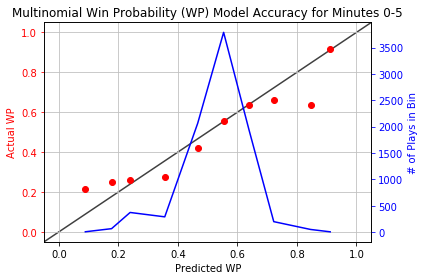


Minutes Elapsed 0-5:
Multinomial Model Correlation between Predicted and Actual WP: 0.9556477010404834
Multinomial Model WP Brier Score: 0.2189865502054157


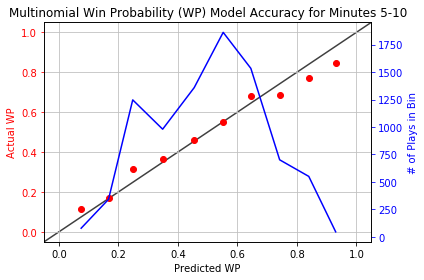


Minutes Elapsed 5-10:
Multinomial Model Correlation between Predicted and Actual WP: 0.9932930685587513
Multinomial Model WP Brier Score: 0.20568068882812948


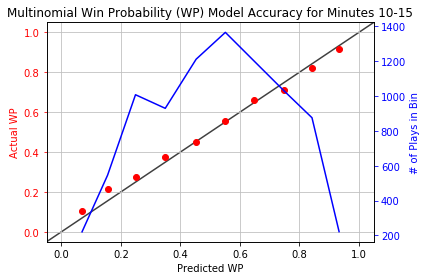


Minutes Elapsed 10-15:
Multinomial Model Correlation between Predicted and Actual WP: 0.9985876499091365
Multinomial Model WP Brier Score: 0.19052727116801157


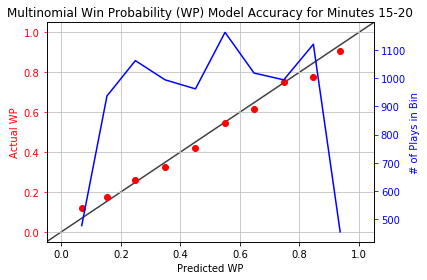


Minutes Elapsed 15-20:
Multinomial Model Correlation between Predicted and Actual WP: 0.9962950075506537
Multinomial Model WP Brier Score: 0.17664598702351625


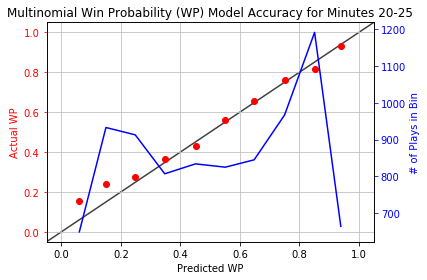


Minutes Elapsed 20-25:
Multinomial Model Correlation between Predicted and Actual WP: 0.9956134087886596
Multinomial Model WP Brier Score: 0.17126404572848175


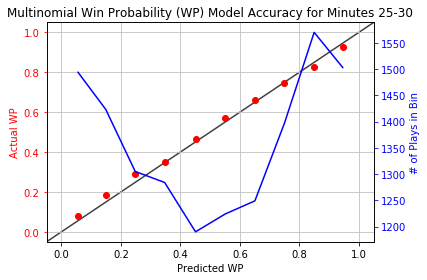


Minutes Elapsed 25-30:
Multinomial Model Correlation between Predicted and Actual WP: 0.9991539222284673
Multinomial Model WP Brier Score: 0.15350015424058613


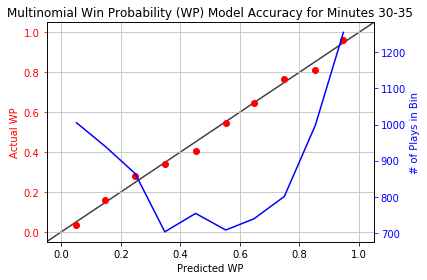


Minutes Elapsed 30-35:
Multinomial Model Correlation between Predicted and Actual WP: 0.9967302112755116
Multinomial Model WP Brier Score: 0.13614165784172713


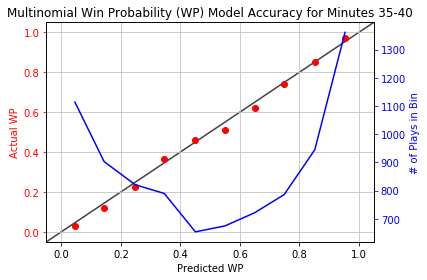


Minutes Elapsed 35-40:
Multinomial Model Correlation between Predicted and Actual WP: 0.9980516065565266
Multinomial Model WP Brier Score: 0.12534661615546128


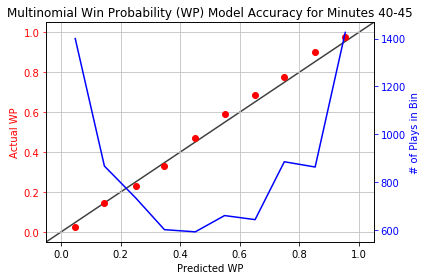


Minutes Elapsed 40-45:
Multinomial Model Correlation between Predicted and Actual WP: 0.9987531374420855
Multinomial Model WP Brier Score: 0.10961690511651834


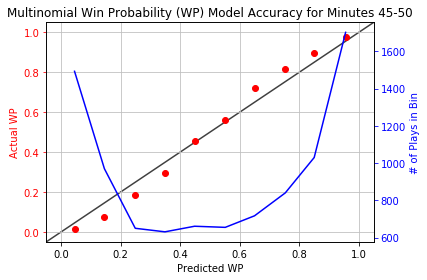


Minutes Elapsed 45-50:
Multinomial Model Correlation between Predicted and Actual WP: 0.9960663479517097
Multinomial Model WP Brier Score: 0.09575887036152358


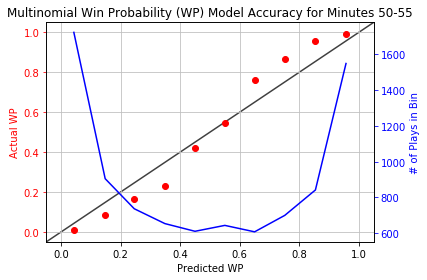


Minutes Elapsed 50-55:
Multinomial Model Correlation between Predicted and Actual WP: 0.98938498780643
Multinomial Model WP Brier Score: 0.08073625928112625


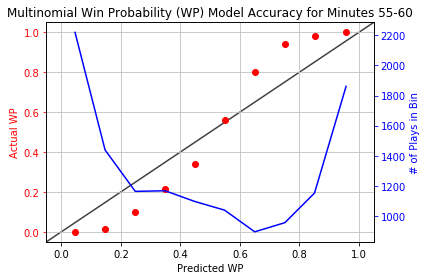


Minutes Elapsed 55-60:
Multinomial Model Correlation between Predicted and Actual WP: 0.9789801747126009
Multinomial Model WP Brier Score: 0.07110305074067015


In [19]:
multinomial_results = calculate_WP_accuracy(test_data, num_buckets, "Multinomial", "aaron_multinomial_WP")

### Logistic Model Performance

Logit:


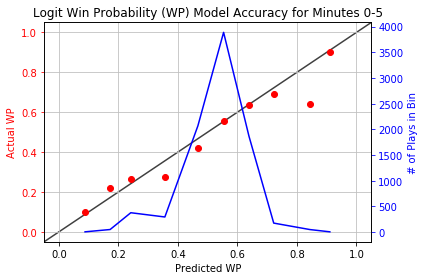


Minutes Elapsed 0-5:
Logit Model Correlation between Predicted and Actual WP: 0.9715688402960858
Logit Model WP Brier Score: 0.21900800896367467


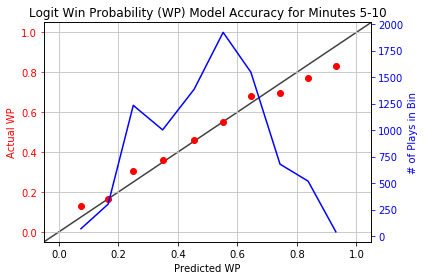


Minutes Elapsed 5-10:
Logit Model Correlation between Predicted and Actual WP: 0.9928332127668412
Logit Model WP Brier Score: 0.20551033523546888


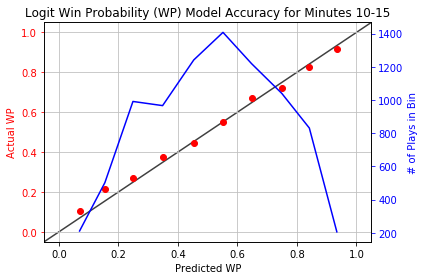


Minutes Elapsed 10-15:
Logit Model Correlation between Predicted and Actual WP: 0.9984327009326884
Logit Model WP Brier Score: 0.19041220911693785


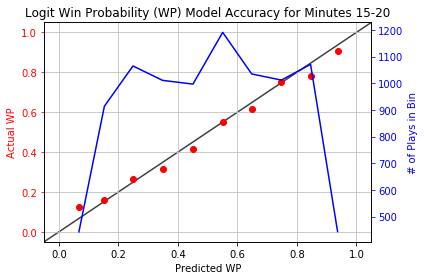


Minutes Elapsed 15-20:
Logit Model Correlation between Predicted and Actual WP: 0.9957993566916659
Logit Model WP Brier Score: 0.17658193068407052


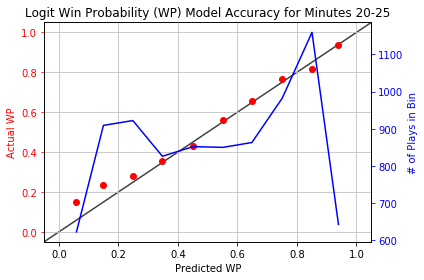


Minutes Elapsed 20-25:
Logit Model Correlation between Predicted and Actual WP: 0.9957953526313044
Logit Model WP Brier Score: 0.17120712058083876


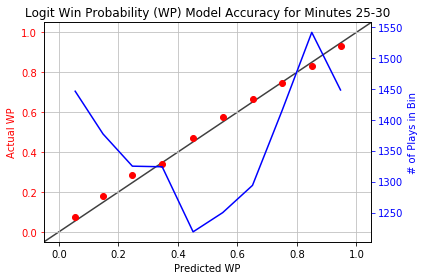


Minutes Elapsed 25-30:
Logit Model Correlation between Predicted and Actual WP: 0.9988634001928717
Logit Model WP Brier Score: 0.15343401634877502


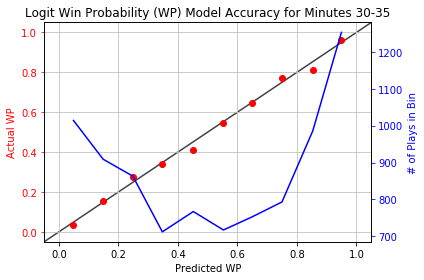


Minutes Elapsed 30-35:
Logit Model Correlation between Predicted and Actual WP: 0.9970111561113889
Logit Model WP Brier Score: 0.13611883218924575


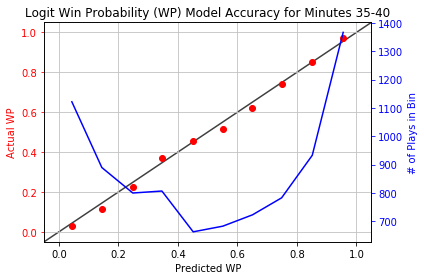


Minutes Elapsed 35-40:
Logit Model Correlation between Predicted and Actual WP: 0.9981483164096923
Logit Model WP Brier Score: 0.12533673901784015


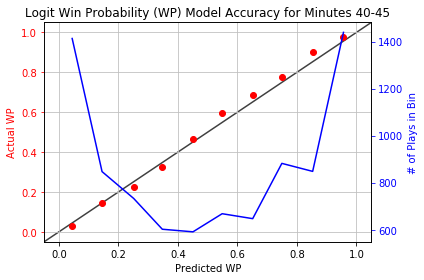


Minutes Elapsed 40-45:
Logit Model Correlation between Predicted and Actual WP: 0.9984527755328251
Logit Model WP Brier Score: 0.10960780894392642


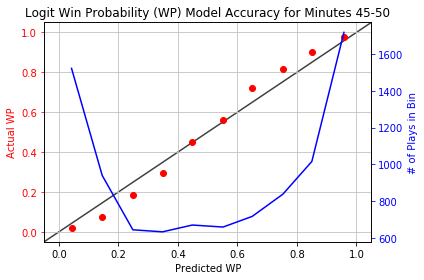


Minutes Elapsed 45-50:
Logit Model Correlation between Predicted and Actual WP: 0.9958095145823918
Logit Model WP Brier Score: 0.0957530785554859


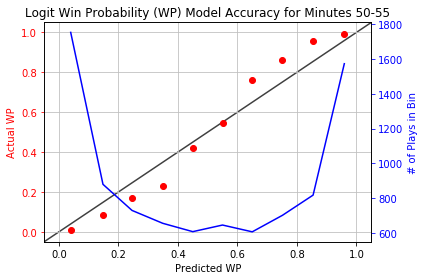


Minutes Elapsed 50-55:
Logit Model Correlation between Predicted and Actual WP: 0.988821800510365
Logit Model WP Brier Score: 0.08065175090063156


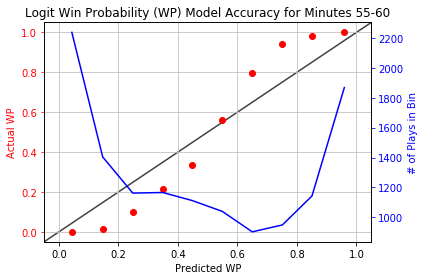


Minutes Elapsed 55-60:
Logit Model Correlation between Predicted and Actual WP: 0.9781770945000956
Logit Model WP Brier Score: 0.0712462294980688


In [20]:
logit_results = calculate_WP_accuracy(test_data, num_buckets, "Logit", "aaron_logit_WP")

### Random Forest Model Performance

Random Forest:


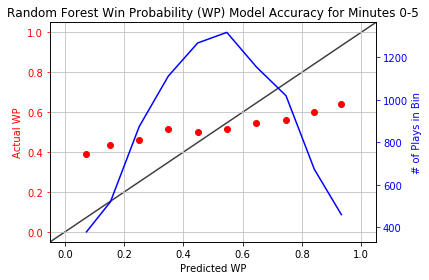


Minutes Elapsed 0-5:
Random Forest Model Correlation between Predicted and Actual WP: 0.973066674697238
Random Forest Model WP Brier Score: 0.2604662028153975


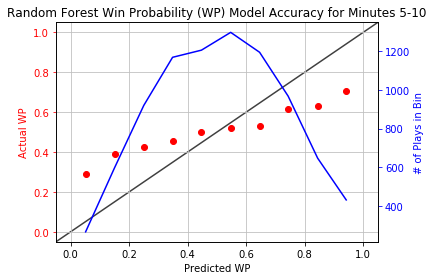


Minutes Elapsed 5-10:
Random Forest Model Correlation between Predicted and Actual WP: 0.9830988065411648
Random Forest Model WP Brier Score: 0.24392815319418737


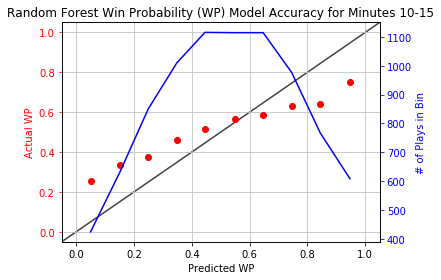


Minutes Elapsed 10-15:
Random Forest Model Correlation between Predicted and Actual WP: 0.9869692242166787
Random Forest Model WP Brier Score: 0.23202933860163188


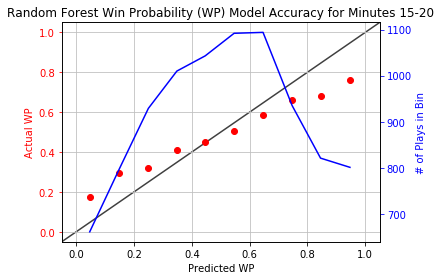


Minutes Elapsed 15-20:
Random Forest Model Correlation between Predicted and Actual WP: 0.9952910928873862
Random Forest Model WP Brier Score: 0.21333854879188296


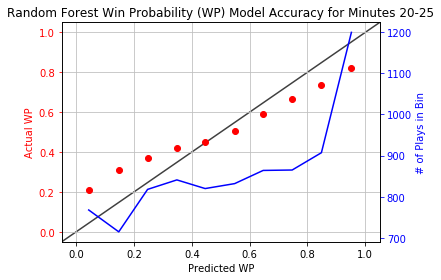


Minutes Elapsed 20-25:
Random Forest Model Correlation between Predicted and Actual WP: 0.9940166088501109
Random Forest Model WP Brier Score: 0.20645322706053773


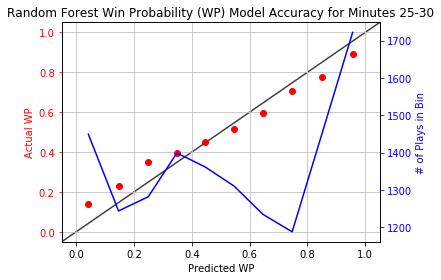


Minutes Elapsed 25-30:
Random Forest Model Correlation between Predicted and Actual WP: 0.9965094078264697
Random Forest Model WP Brier Score: 0.1793830918315152


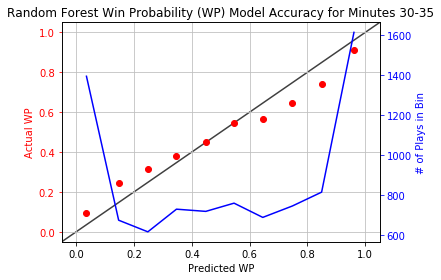


Minutes Elapsed 30-35:
Random Forest Model Correlation between Predicted and Actual WP: 0.9904340216675399
Random Forest Model WP Brier Score: 0.16089365160463617


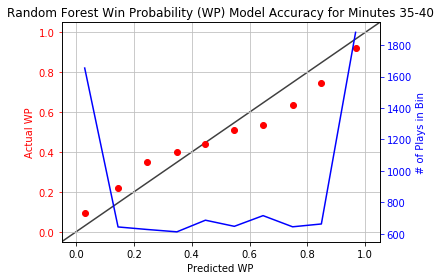


Minutes Elapsed 35-40:
Random Forest Model Correlation between Predicted and Actual WP: 0.9835116841931847
Random Forest Model WP Brier Score: 0.15181195601586855


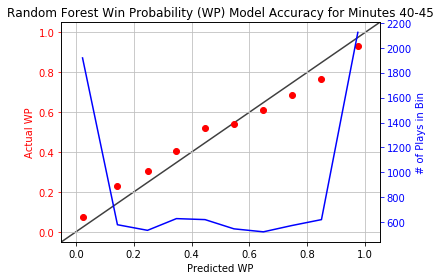


Minutes Elapsed 40-45:
Random Forest Model Correlation between Predicted and Actual WP: 0.9927095721253332
Random Forest Model WP Brier Score: 0.13090318483275784


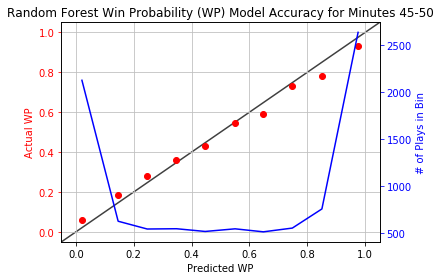


Minutes Elapsed 45-50:
Random Forest Model Correlation between Predicted and Actual WP: 0.9980266199309237
Random Forest Model WP Brier Score: 0.11307246422671631


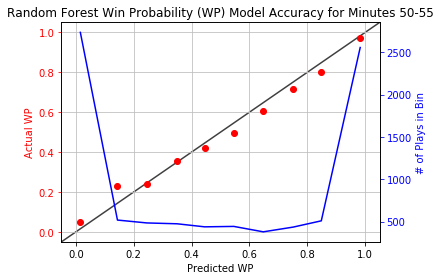


Minutes Elapsed 50-55:
Random Forest Model Correlation between Predicted and Actual WP: 0.9944613141728191
Random Forest Model WP Brier Score: 0.08957866508476145


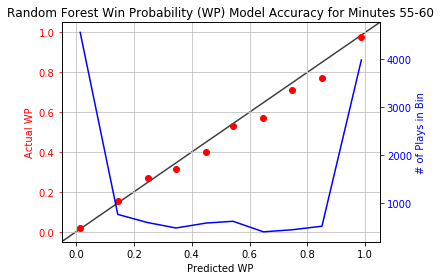


Minutes Elapsed 55-60:
Random Forest Model Correlation between Predicted and Actual WP: 0.9951187795778897
Random Forest Model WP Brier Score: 0.061265151340111616


In [21]:
rf_results = calculate_WP_accuracy(test_data, num_buckets, "Random Forest", "aaron_rf_WP")

Save WP model performance results to "compare_WP_models.csv" for further investigation.

In [22]:
results = pd.concat([multinomial_results.set_index("Minutes"), logit_results.set_index("Minutes")], axis=1, join="inner").reset_index()
results = pd.concat([results.set_index("Minutes"), rf_results.set_index("Minutes")], axis=1, join="inner").reset_index()

In [23]:
results.to_csv("compare_WP_models.csv", encoding="utf-8", index=False)